## Mnist Classification

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchsummary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# if GPU is available use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Datasets

In [2]:
train_dataset = torchvision.datasets.MNIST(root="./data",
                                         train=True,
                                         transform=torchvision.transforms.ToTensor(),
                                         download=True,
                                         )
test_dataset = torchvision.datasets.MNIST(root="./data",
                                         train=False,
                                         transform=torchvision.transforms.ToTensor(),
                                         download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=64,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=64,
                                              shuffle=True)

print(f'Number of train samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

Number of train samples: 60000
Number of test samples: 10000


C:\Users\shres\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Iterating and visualizing the dataset

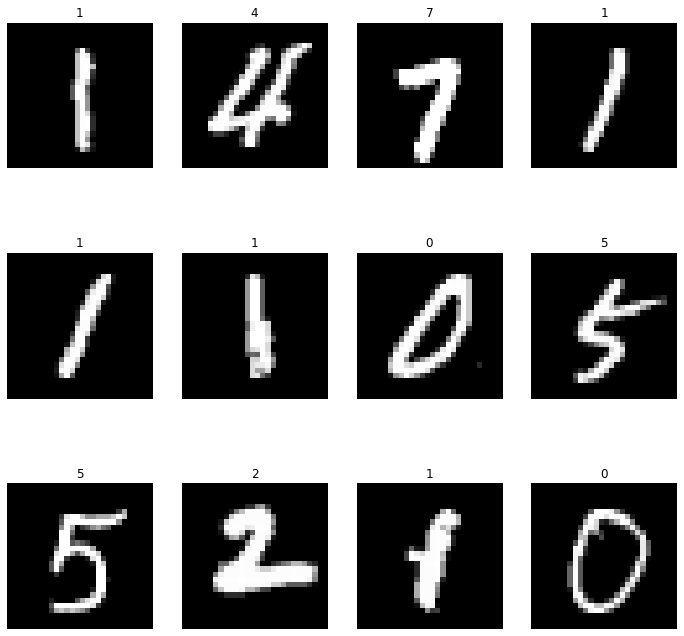

In [3]:
figure = plt.figure(figsize=(12,12))
n_rows, n_cols = 3, 4

for i in range(1, n_rows*n_cols + 1):
    # choose a samle index randomly
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(n_rows, n_cols, i)
    plt.title(label)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
    

### Define a Model

In [4]:
class MNISTClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_layer_1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear_layer_2 = nn.Linear(hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
                
    def forward(self, X):
        out = self.flatten(X)
        out = self.linear_layer_1(out)
        out = self.relu(out)
        out = self.linear_layer_2(out)
        out = self.softmax(out)
        return out
    
# Hyperparaters to build model
input_size = 784
hidden_size = 256
num_classes = 10

mnist_classifier = MNISTClassifier(input_size, hidden_size, num_classes).to(device)

In [5]:
# summary of the model

torchsummary.summary(mnist_classifier, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
           Softmax-5                   [-1, 10]               0
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


In [6]:
# plot the model with tensorboard
dataiter = iter(train_dataloader)
image, label = dataiter.next()

writer = SummaryWriter()
writer.add_graph(mnist_classifier, image)
writer.close()

<img src='img/model_grph.png'/>

### Train the Model

In [7]:
# define loss and optimizer

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classifier.parameters())

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    n_correct, loss = 0, 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)      
        pred_labels = model(images)
        loss = loss_fn(pred_labels, labels)      
        # Backprpagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        n_correct += (pred_labels.argmax(dim=1) == labels).sum().item()
    accuracy = 100*n_correct/size
    print(f"train_accuracy: {accuracy:>0.1f}%, train_loss: {loss:>8f}") 
    return accuracy, loss
            
def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, n_correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred_labels = model(images)
            val_loss += loss_fn(pred_labels, labels).item()
            n_correct += (pred_labels.argmax(dim=1) == labels).sum().item()
    val_loss /= num_batches
    val_accuracy = 100*n_correct/size
    print(f"val_accuracy: {val_accuracy:>0.1f}%, val_loss: {val_loss:>8f}")
    return val_accuracy, val_loss
            
    
            
epochs = 30          
for t in range(epochs):
    print(f"Epoch: {t+1}-------------------------------")
    train_acc, train_loss = train_loop(train_dataloader, mnist_classifier, loss_fn, optimizer)
    # for tensorboard 
    writer.add_scalar('train/accuracy', train_acc, t)
    writer.add_scalar('train/loss', train_loss, t)
    
    val_acc, val_loss = validation_loop(test_dataloader, mnist_classifier, loss_fn)
    # for tensorboard
    writer.add_scalar('val/accuracy', val_acc, t)
    writer.add_scalar('val/loss', val_loss, t)
print("Done!")

Epoch: 1-------------------------------
train_accuracy: 89.6%, train_loss: 1.511387
val_accuracy: 93.9%, val_loss: 1.528159
Epoch: 2-------------------------------
train_accuracy: 94.5%, train_loss: 1.496842
val_accuracy: 95.3%, val_loss: 1.512953
Epoch: 3-------------------------------
train_accuracy: 95.9%, train_loss: 1.486606
val_accuracy: 96.1%, val_loss: 1.503573
Epoch: 4-------------------------------
train_accuracy: 96.8%, train_loss: 1.542042
val_accuracy: 96.8%, val_loss: 1.496252
Epoch: 5-------------------------------
train_accuracy: 97.4%, train_loss: 1.480743
val_accuracy: 96.8%, val_loss: 1.495276
Epoch: 6-------------------------------
train_accuracy: 97.7%, train_loss: 1.502471
val_accuracy: 97.2%, val_loss: 1.490984
Epoch: 7-------------------------------
train_accuracy: 98.0%, train_loss: 1.497097
val_accuracy: 97.2%, val_loss: 1.491092
Epoch: 8-------------------------------
train_accuracy: 98.3%, train_loss: 1.461814
val_accuracy: 97.4%, val_loss: 1.488575
Epoch: 9

### Plot Accuracy, Loss over epochs

<img src='img/loss_accuracy_plot.png'/>